This file adds the branches chi, delta phi, delta eta, and Mjj to the 1991-1993 dijet event ROOT files as well as contains a class for reweighting PDFs. The added columns of chi, delta phi, delta eta, and Mjj are saved in an exported ROOT file and their normalized plots are shown. This exported ROOT file is later read by the class reweighter. The reweighter produces another ROOT file which has the three pdf systems saved in addition. At the end of this file are the plots comparing the three pdf systems and their ratio.

In [1]:
import ROOT
import numpy as np
import awkward as ak
import lhapdf
import matplotlib.pyplot as plt

# print("Installed PDF sets:", lhapdf.getInstalledPDFSets())
# print("LHAPDF_DATA_PATH =", lhapdf.getPDFPath())
#print(lhapdf.__file__)
#print(lhapdf.paths())  # Show where it's looking for PDF sets
#print(lhapdf.availablePDFSets())

file_list = [
    "/afs/cern.ch/user/k/kmonagha/Pythia_projects/dijet_events_1991.root",
    "/afs/cern.ch/user/k/kmonagha/Pythia_projects/dijet_events_1992.root",
    "/afs/cern.ch/user/k/kmonagha/Pythia_projects/dijet_events_1993.root"
] 
treeName = "dijets"

d = ROOT.RDataFrame(treeName, file_list)

lhapdf.setPaths(["/cvmfs/sft.cern.ch/lcg/external/lhapdfsets/current/"])
ROOT.gSystem.Setenv("LHAPDF_DATA_PATH", "/cvmfs/sft.cern.ch/lcg/external/lhapdfsets/current/")

In [2]:
ROOT.gInterpreter.Declare('#include "Math/VectorUtil.h"')

d = d.Define("jet1_vec", "ROOT::Math::PtEtaPhiEVector(jet1_pt, jet1_eta, jet1_phi, jet1_E)")
d = d.Define("jet2_vec", "ROOT::Math::PtEtaPhiEVector(jet2_pt, jet2_eta, jet2_phi, jet2_E)")

d = d.Define("Mjj", "(jet1_vec + jet2_vec).M()")
d = d.Define("DeltaEta", "fabs(jet1_eta - jet2_eta)")
d = d.Define("DeltaPhi", "ROOT::Math::VectorUtil::DeltaPhi(jet1_vec, jet2_vec)")

d = d.Define("y1", "jet1_vec.Rapidity()")
d = d.Define("y2", "jet2_vec.Rapidity()")
d = d.Define("DeltaY", "fabs(y1 - y2)")
d = d.Define("chi", "exp(DeltaY)")

output_file = "dijet_events_vectors_1991-1993.root"
output_tree = "dijets"

d.Snapshot(output_tree, output_file)

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x5630bdf31fa0>

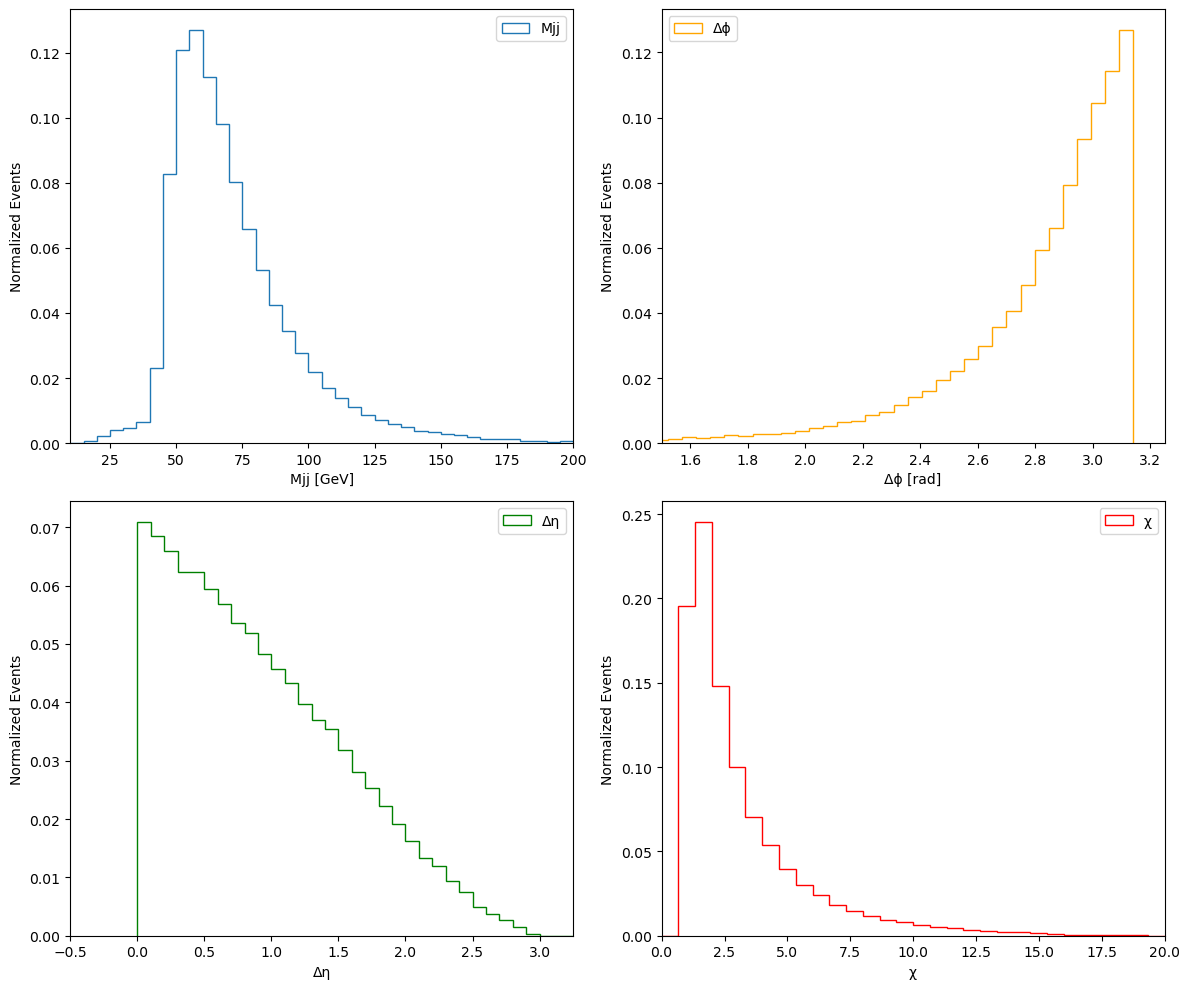

In [3]:
#Create Histograms for variables
 
h_mjj  = d.Histo1D(("h_mjj", "M_{jj};M_{jj} [GeV];Events", 100, 0, 500), "Mjj")
h_dphi = d.Histo1D(("h_dphi", "Δϕ;Δϕ [rad];Events", 64, 0, np.pi), "DeltaPhi")
h_deta = d.Histo1D(("h_deta", "Δη;Δη;Events", 60, 0, 6), "DeltaEta")
h_chi  = d.Histo1D(("h_chi", "χ;χ = e^{|y₁ - y₂|};Events", 30, 0, 20), "chi")

#Now option to convert to matplotlib

def root_hist_to_numpy(h, normalize=False):
    edges = np.array([h.GetBinLowEdge(i+1) for i in range(h.GetNbinsX()+1)])
    values = np.array([h.GetBinContent(i+1) for i in range(h.GetNbinsX())])

    if normalize and values.sum() > 0:
        values = values / values.sum()

    return edges, values

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Mjj
edges, values = root_hist_to_numpy(h_mjj, normalize=True)
axs[0, 0].hist(edges[:-1], bins=edges, weights=values, histtype='step', label="Mjj")
axs[0, 0].set_xlabel("Mjj [GeV]")
axs[0, 0].set_ylabel("Normalized Events")
axs[0, 0].legend()
axs[0, 0].set_xlim(10,200)

# DeltaPhi
edges, values = root_hist_to_numpy(h_dphi, normalize=True)
axs[0, 1].hist(edges[:-1], bins=edges, weights=values, histtype='step', label="Δϕ", color='orange')
axs[0, 1].set_xlabel("Δϕ [rad]")
axs[0, 1].set_ylabel("Normalized Events")
axs[0, 1].legend()
axs[0, 1].set_xlim(1.5,3.25)

# DeltaEta
edges, values = root_hist_to_numpy(h_deta, normalize=True)
axs[1, 0].hist(edges[:-1], bins=edges, weights=values, histtype='step', label="Δη", color='green')
axs[1, 0].set_xlabel("Δη")
axs[1, 0].set_ylabel("Normalized Events")
axs[1, 0].legend()
axs[1, 0].set_xlim(-.5,3.25)

# Chi
edges, values = root_hist_to_numpy(h_chi, normalize=True)
axs[1, 1].hist(edges[:-1], bins=edges, weights=values, histtype='step', label="χ", color='red')
axs[1, 1].set_xlabel("χ")
axs[1, 1].set_ylabel("Normalized Events")
axs[1, 1].legend()
axs[1, 1].set_xlim(0,20)

plt.tight_layout()
plt.savefig("dijet_observables.png")
plt.show()

In [4]:
class PDFReweighter:
    def __init__(self, orig_pdf="NNPDF23_lo_as_0130_qed", target_pdfs=["MSHT20nlo_as120", "CT18NLO","NNPDF40_nlo_as_01180"]):
        self.orig_pdf = lhapdf.getPDFSet(orig_pdf).mkPDF(0)
        self.target_pdfs = {
            name: lhapdf.getPDFSet(name).mkPDF(0)
            for name in target_pdfs
        }

    def compute_weights(self, x1, x2, Q2, id1, id2):
        # Avoid invalid inputs
        if x1 <= 0 or x2 <= 0:
            return {name: 0.0 for name in self.target_pdfs}

        try:
            # Original PDF values
            pdf1_orig = self.orig_pdf.xfxQ2(id1, x1, Q2) / x1
            pdf2_orig = self.orig_pdf.xfxQ2(id2, x2, Q2) / x2
            denom = pdf1_orig * pdf2_orig
            if denom == 0:
                return {name: 0.0 for name in self.target_pdfs}

            # Compute reweighting for each target PDF
            weights = {}
            for name, pdf in self.target_pdfs.items():
                pdf1_new = pdf.xfxQ2(id1, x1, Q2) / x1
                pdf2_new = pdf.xfxQ2(id2, x2, Q2) / x2
                numer = pdf1_new * pdf2_new
                weights[name] = numer / denom
            return weights
        except Exception:
            return {name: 0.0 for name in self.target_pdfs}

    def add_reweight_to_root_file(self, input_file, output_file, tree_name="dijets"):
        infile = ROOT.TFile.Open(input_file, "READ")
        tree = infile.Get(tree_name)

        outfile = ROOT.TFile(output_file, "RECREATE")
        new_tree = tree.CloneTree(0)

        # Create numpy arrays for new branches
        weight_branches = {}
        branch_arrays = {}

        for name in self.target_pdfs:
            branch_arrays[name] = np.zeros(1, dtype='f8')
            weight_branches[name] = new_tree.Branch(
                f"weight_{name}", branch_arrays[name], f"weight_{name}/D"
            )

        # Loop through events to fill new branches
        for event in tree:
            weights = self.compute_weights(event.x1, event.x2, event.Q2, event.id1, event.id2)
            for name in self.target_pdfs:
                branch_arrays[name][0] = weights[name]
            new_tree.Fill()

        # Write the tree and close files
        new_tree.Write()
        outfile.Close()
        infile.Close()
        print(f"New ROOT file with weights saved to: {output_file}")


reweighter = PDFReweighter()
reweighter.add_reweight_to_root_file("dijet_events_vectors_1991-1993.root", "dijet_events_vec_1991-1993_weights.root")

New ROOT file with weights saved to: dijet_events_vec_1991-1993_weights.root
LHAPDF 6.5.5 loading /cvmfs/sft.cern.ch/lcg/external/lhapdfsets/current/NNPDF23_lo_as_0130_qed/NNPDF23_lo_as_0130_qed_0000.dat
NNPDF23_lo_as_0130_qed PDF set, member #0, version 1; LHAPDF ID = 247000
LHAPDF 6.5.5 loading /cvmfs/sft.cern.ch/lcg/external/lhapdfsets/current/MSHT20nlo_as120/MSHT20nlo_as120_0000.dat
MSHT20nlo_as120 PDF set, member #0, version 3; LHAPDF ID = 27200
LHAPDF 6.5.5 loading /cvmfs/sft.cern.ch/lcg/external/lhapdfsets/current/CT18NLO/CT18NLO_0000.dat
CT18NLO PDF set, member #0, version 1; LHAPDF ID = 14400
LHAPDF 6.5.5 loading /cvmfs/sft.cern.ch/lcg/external/lhapdfsets/current/NNPDF40_nlo_as_01180/NNPDF40_nlo_as_01180_0000.dat
NNPDF40_nlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331700


Example weights:
Event 0: MSHT=0.9912836195306408, CT18=1.0294949956455377, NNPDF=0.988409560886
Event 1: MSHT=0.7694078653410074, CT18=0.7799875175194453, NNPDF=0.7269215933481246
Event 2: MSHT=0.8979880116732007, CT18=0.9008104882705591, NNPDF=0.8882719353059666
Event 3: MSHT=1.0281976125969845, CT18=1.0475334009191883, NNPDF=0.946130678741891
Event 4: MSHT=0.7720265114703593, CT18=0.7989309784323922, NNPDF=0.7576850836828668
Event 5: MSHT=1.261127073339869, CT18=1.1382005678325822, NNPDF=1.2493260352158546
Event 6: MSHT=0.4737055053769029, CT18=0.49769827961410096, NNPDF=0.41387721823316936
Event 7: MSHT=0.9652545663109922, CT18=1.0026955485413314, NNPDF=0.9678552702005018
Event 8: MSHT=0.9559215571248936, CT18=0.9967262079852364, NNPDF=0.9156404412922746
Event 9: MSHT=0.8477545594017222, CT18=0.8687216285972162, NNPDF=0.8535198250826864


/tmp/kmonagha/ipykernel_1314442/2432118820.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


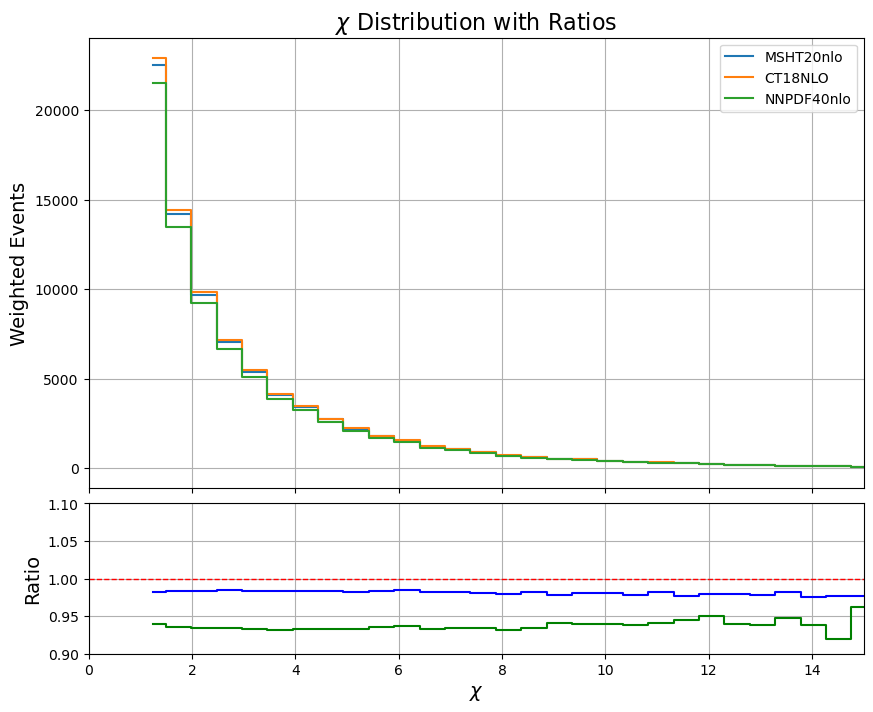

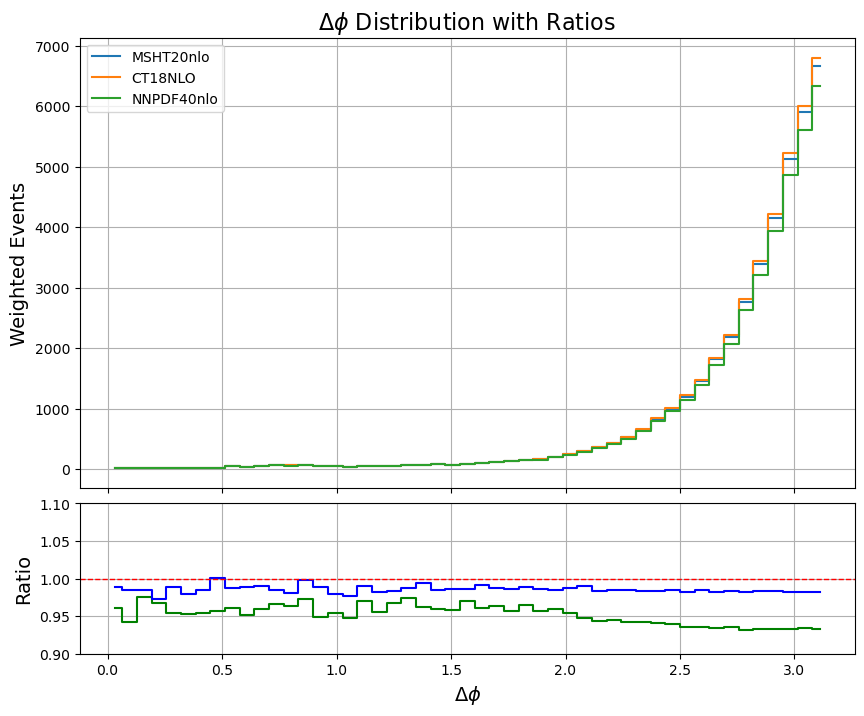

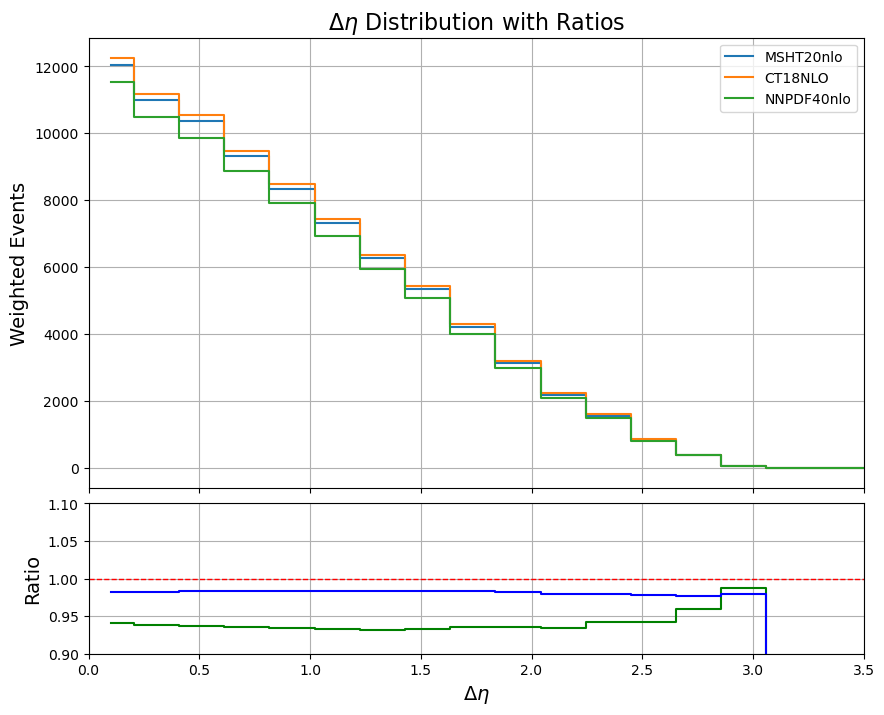

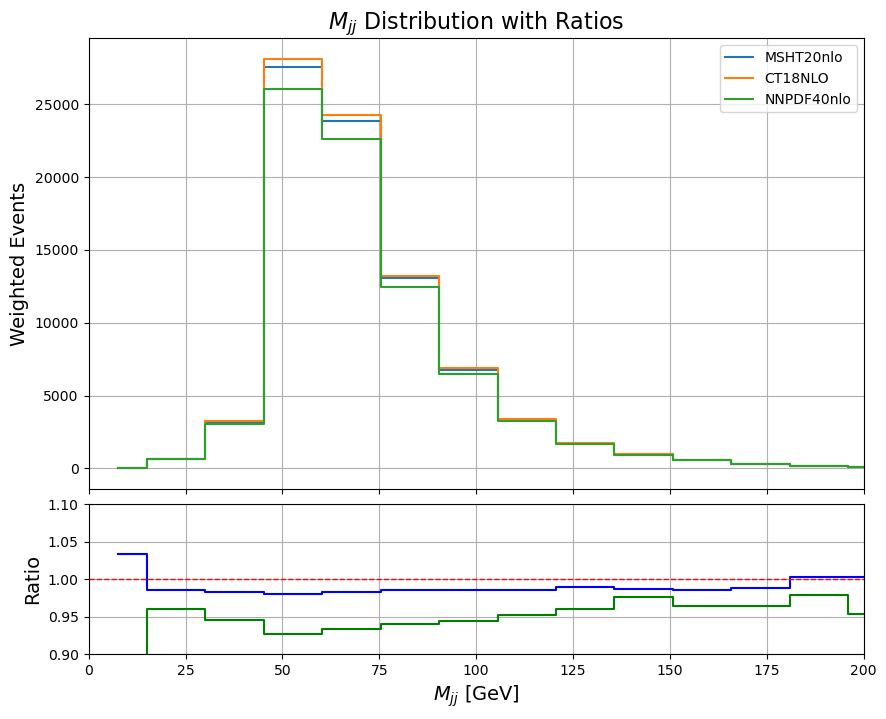

In [8]:
# Open the updated ROOT file
import uproot
import matplotlib.gridspec as gridspec

file = uproot.open("dijet_events_vec_1991-1993_weights.root")
tree = file["dijets"]

# Load columns and the weights
data = tree.arrays(["chi", "DeltaEta","DeltaPhi","Mjj","weight_MSHT20nlo_as120", "weight_CT18NLO", "weight_NNPDF40_nlo_as_01180"], library="np")

chi = data["chi"]
delta_phi = data["DeltaPhi"]
delta_eta = data["DeltaEta"]
Mjj = data["Mjj"]
weights_msht = data["weight_MSHT20nlo_as120"]
weights_ct18 = data["weight_CT18NLO"]
weights_nnpdf = data["weight_NNPDF40_nlo_as_01180"]


print("Example weights:")
for i in range(10):
    print(f"Event {i}: MSHT={weights_msht[i]}, CT18={weights_ct18[i]}, NNPDF={weights_nnpdf[i]}")


weights_dict = {
    "MSHT20nlo": weights_msht,
    "CT18NLO": weights_ct18,
    "NNPDF40nlo": weights_nnpdf
}

def plot_with_ratio(x, weights_dict, ratio_pairs, bins, xlabel, title, xlim=None, ylim=None, normalize=False):
    """
    Plots observable distribution and ratio of two selected PDFs.
    """
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    ratio_colors = {
            ("NNPDF40nlo", "CT18NLO"): "green",
            ("MSHT20nlo", "CT18NLO"): "blue"
        }
    
    # Create subplot layout
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

    # Upper plot: Distributions
    ax0 = fig.add_subplot(gs[0])
    for label, w in weights_dict.items():
        h, _ = np.histogram(x, bins=bins, weights=w)
        if normalize:
            h = h / np.sum(h) if np.sum(h) > 0 else h
        ax0.step(bin_centers, h, where='mid', label=label, linewidth=1.5)        

    ax0.set_ylabel("Weighted Events" if not normalize else "Normalized Events", fontsize=14)
    ax0.set_title(f"{title} with Ratios", fontsize=16)
    ax0.legend()
    ax0.grid(True)
    ax0.tick_params(labelbottom=False)
    if xlim:
        ax0.set_xlim(*xlim)
    if ylim:
        ax0.set_ylim(*ylim)

    # Lower plot: Ratio
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    for num, den in ratio_pairs:
        hist_num, _ = np.histogram(x, bins=bins, weights=weights_dict[num])
        hist_den, _ = np.histogram(x, bins=bins, weights=weights_dict[den])
        if normalize:
            hist_num = hist_num / np.sum(hist_num) if np.sum(hist_num) > 0 else hist_num
            hist_den = hist_den / np.sum(hist_den) if np.sum(hist_den) > 0 else hist_den
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = np.divide(hist_num, hist_den, out=np.zeros_like(hist_num), where=hist_den != 0)

        color = ratio_colors.get((num, den), "black")
        ax1.plot(bin_centers, ratio, drawstyle='steps-mid', color=color, label=rf"$\frac{{{num}}}{{{den}}}$")
        
    ax1.axhline(1.0, color='red', linestyle='--', linewidth=1)
    ax1.set_xlabel(xlabel, fontsize=14)
    ax1.set_ylabel("Ratio", fontsize=14)
    ax1.grid(True)
    ax1.set_ylim(0.9, 1.1)
    if xlim:
        ax1.set_xlim(*xlim)
    if ylim:
        ax1.set_ylim(*ylim)

    plt.tight_layout()
    plt.show()

# ------------------ Plot Calls ------------------

# χ Distribution
plot_with_ratio(chi, weights_dict, ratio_pairs=[("NNPDF40nlo","CT18NLO"),("MSHT20nlo","CT18NLO")],
                bins=np.linspace(1, 30, 60), xlabel=r"$\chi$", title=r"$\chi$ Distribution",xlim=(0, 15),normalize=False)

# Δφ Distribution
plot_with_ratio(delta_phi, weights_dict, ratio_pairs=[("NNPDF40nlo","CT18NLO"),("MSHT20nlo","CT18NLO")],
                bins=np.linspace(0, np.pi, 50), xlabel=r"$\Delta\phi$", title=r"$\Delta\phi$ Distribution",normalize=False)

# Δη Distribution
plot_with_ratio(delta_eta, weights_dict, ratio_pairs=[("NNPDF40nlo","CT18NLO"),("MSHT20nlo","CT18NLO")],
                bins=np.linspace(0, 10, 50), xlabel=r"$\Delta\eta$", title=r"$\Delta\eta$ Distribution", xlim=(0, 3.5),normalize=False)

# Mjj Distribution
plot_with_ratio(Mjj, weights_dict, ratio_pairs=[("NNPDF40nlo","CT18NLO"),("MSHT20nlo","CT18NLO")],
                bins=np.linspace(0, 3000, 200), xlabel=r"$M_{jj}$ [GeV]", title=r"$M_{jj}$ Distribution", xlim=(0, 200),normalize=False)

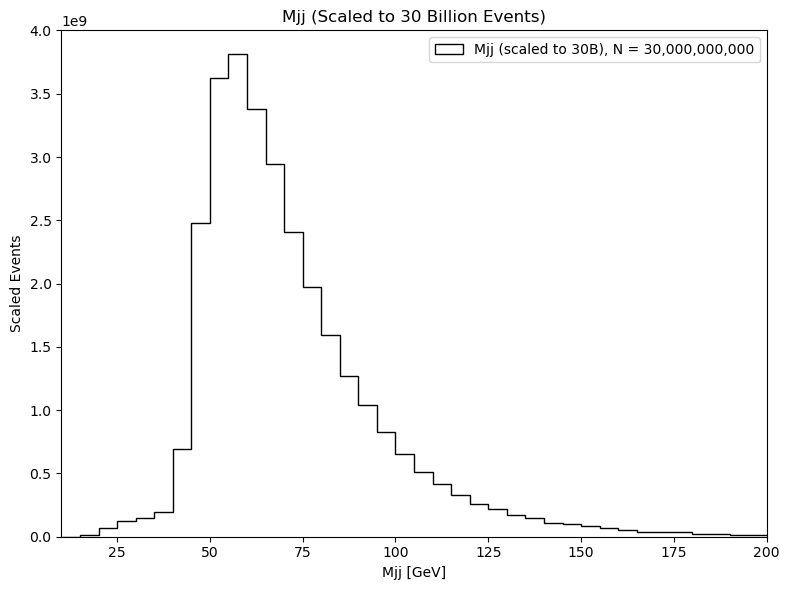

In [ ]:
# New figure for non-normalized Mjj, scaled to 300 billion events
fig2, ax = plt.subplots(figsize=(8, 6))
edges, values = root_hist_to_numpy(h_mjj, normalize=False)
total_events = int(values.sum())

# Scale values
scale_factor = 30e9 / total_events
scaled_values = values * scale_factor

ax.hist(edges[:-1], bins=edges, weights=scaled_values, histtype='step', color='black',
        label=f"Mjj (scaled to 30B), N = {30_000_000_000:,.0f}")

ax.set_xlabel("Mjj [GeV]")
ax.set_ylabel("Scaled Events")
ax.legend()
ax.set_xlim(10, 200)
plt.title("Mjj (Scaled to 30 Billion Events)")
plt.tight_layout()
plt.savefig("mjj_scaled_300B.png")
plt.show()



From the Pythia generator, find that sigma = 28.53 μb. We have an efficiency of 3.5% and a luminosity of 30 fb-1

In [28]:
efficiency = 0.035
sigma = 28.53 #μb
luminosity = 30 #fb-1
sigma = efficiency*sigma

print(f"The cross section for the dijet is {sigma:.4e} μb ~ 1μb")

sigma = 1*10e9 #fb
print (sigma)
N = sigma*luminosity

print(f"N = {N:.4e} ~ 30 billion")

The cross section for the dijet is 9.9855e-01 μb ~ 1μb
10000000000.0
N = 3.0000e+11 ~ 30 billion
